<a href="https://colab.research.google.com/github/imtiaz114/Brain_tumor_detection_from_2D_MRI_images/blob/main/Brain_tumor_detection_CNN_architecutre_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Baseline

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import tensorflow_datasets as tfds

import shutil, random, os,glob
import cv2
import tempfile

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224,224)
INITIAL_EPOCHS = 250
LR = 0.001

## Prepare the dataset

In [6]:
#counting files
os.chdir('/content/drive/MyDrive/Dataset_2/final_dataset/Dataset2/80_20/test/no/')
count = 0
for f in glob.glob("*"):
  count += 1

print(count)

79


In [7]:
x_train = np.zeros(((2612,IMG_SIZE[0],IMG_SIZE[1],3)))
x_test  = np.zeros(((653,IMG_SIZE[0],IMG_SIZE[1],3)))
y_train = np.zeros(2612,dtype = np.uint8)
y_test  = np.zeros(653,dtype = np.uint8)

In [8]:
#train yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/final_dataset/Dataset2/80_20/train/yes/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  #img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_train[count,:,:,:]  = img
  y_train[count] = 1
  #print(count)
  count += 1

In [9]:
#train no
dirpath = '/content/drive/MyDrive/Dataset_2/final_dataset/Dataset2/80_20/train/no/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  #img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_train[count,:,:,:]  = img
  y_train[count] = 0
  #print(count)
  count += 1

In [10]:
#test yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/final_dataset/Dataset2/80_20/test/yes/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  #img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_test[count,:,:,:]  = img
  y_test[count] = 1
  #print(count)
  count += 1

In [11]:
#test no
dirpath = '/content/drive/MyDrive/Dataset_2/final_dataset/Dataset2/80_20/test/no/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  #img = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
  x_test[count,:,:,:]  = img
  y_test[count] = 0
  #print(count)
  count += 1

In [12]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(2612, 224, 224, 3) (2612,) (653, 224, 224, 3) (653,)


### verifying

In [13]:
print(np.sum(y_train == 0),np.sum(y_test == 0))
print(np.sum(y_train == 1),np.sum(y_test == 1))

316 79
2296 574


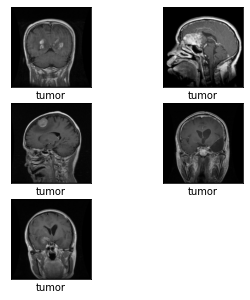

In [14]:
class_names = ['non_tumor','tumor']

plt.figure(figsize=(5,5))

idx = np.random.randint(0,175,5)
i = 0
for i in range(len(idx)):
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[int(idx[i])])
    #print(y_train[idx[i]])
    plt.xlabel(class_names[y_train[idx[i]]])
    i += 1
plt.show()

## Defining the model

In [15]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [16]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = models.Sequential()
  #model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)))
  #model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  #model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR, beta_1=0.9,beta_2=0.999, epsilon=None,amsgrad=False),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

  return model

## Training the model

In [17]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 788544)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               100933760 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 100,935,681
Trainable params: 100,935,681
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [19]:
history = model.fit(x_train,y_train, epochs=INITIAL_EPOCHS,steps_per_epoch=13, batch_size= BATCH_SIZE,callbacks=[early_stopping])

Epoch 1/250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


13/13 [==============================] - 44s 72ms/step - loss: 11.1154 - accuracy: 0.5292 - precision: 0.6916 - recall: 0.5542
Epoch 2/250
13/13 [==============================] - 1s 70ms/step - loss: 0.8189 - accuracy: 0.7640 - precision: 0.8764 - recall: 0.8518
Epoch 3/250
13/13 [==============================] - 1s 71ms/step - loss: 0.5232 - accuracy: 0.7923 - precision: 0.8746 - recall: 0.8900
Epoch 4/250
13/13 [==============================] - 1s 71ms/step - loss: 0.4651 - accuracy: 0.8116 - precision: 0.8706 - recall: 0.9197
Epoch 5/250
13/13 [==============================] - 1s 71ms/step - loss: 0.3267 - accuracy: 0.8274 - precision: 0.8726 - recall: 0.9384
Epoch 6/250
13/13 [==============================] - 1s 70ms/step - loss: 0.3720 - accuracy: 0.8376 - precision: 0.8752 - recall: 0.9485
Epoch 7/250
13/13 [==============================] - 1s 72ms/step - loss: 0.3688 - accuracy: 0.8400 - precision: 0.8760 - recall: 0.9504
Epoch 8/250
13/13 [==============================] 

In [20]:
# Save the weights
model.save_weights('/content/drive/MyDrive/Dataset_2/final_dataset/weights/dataset1_baseline')

## Evaluate the model

In [21]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(x_test,y_test, verbose=2)
print('Accuracy : ' + str(test_acc))
print('Loss : ' + str(test_loss))
print('Precision : ' + str(test_precision))
print('Recall : ' + str(test_recall))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


21/21 - 2s - loss: 0.2352 - accuracy: 0.9905 - precision: 0.9921 - recall: 0.9972
Accuracy : 0.9905270934104919
Loss : 0.235151469707489
Precision : 0.9921084046363831
Recall : 0.9971650242805481


In [22]:
y_pred = model.predict(x_test)

for i in range(len(y_pred)):
  if y_pred[i]>0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

In [23]:
df = pd.DataFrame({'Predicted lables':np.ravel(y_pred), 'True labels':y_test})

In [24]:
df.head(10)

,Predicted lables,True labels
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1
5,1.0,1
6,1.0,1
7,1.0,1
8,1.0,1
9,1.0,1


In [25]:
incorrect_idx = []
correct_idx   = []

for i in range(len(y_pred)):
  if int(y_pred[i]) != y_test[i]:
    incorrect_idx.append(i)
  else:
    correct_idx.append(i)

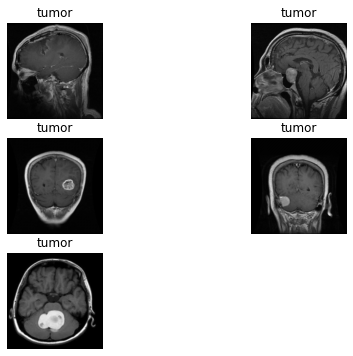

In [26]:
#plotting 5 correctly labeled images
plt.figure(figsize=(8,6))

for i in range(5):
  ax = plt.subplot(3,2, i + 1)
  plt.imshow(x_test[i])
  if y_pred[correct_idx[i]] == 1:
    title = "tumor"
  else :
    title = "non-tumor"

  plt.title(title)
  plt.axis("off")

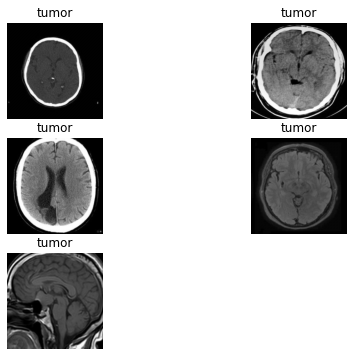

In [27]:
# plotting all the incorrectly labeled images
plt.figure(figsize=(8,6))
plt.title("Incorrect Labels")

#l = len(incorrect_idx)
for i in range(5):
  #ax = plt.subplot(np.ceil(l/2),np.floor(l/2), i + 1)
  ax = plt.subplot(3,2, i + 1)
  plt.imshow(x_test[incorrect_idx[i]])
  if y_pred[incorrect_idx[i]] == 1:
    title = "tumor"
  else :
    title = "non-tumor"

  plt.title(title)
  plt.axis("off")

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [29]:
baseline_results = model.evaluate(x_test,y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.235151469707489
accuracy :  0.9902010560035706
precision :  0.991709291934967
recall :  0.9971994757652283



Legitimate Transactions Detected (True Negatives):  55
Legitimate Transactions Incorrectly Detected (False Positives):  24
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  574
Total Fraudulent Transactions:  574


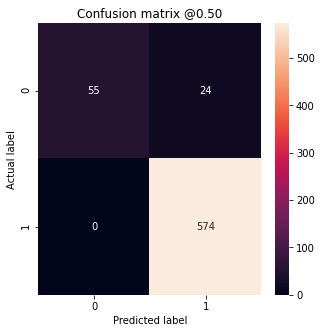

In [30]:
plot_cm(y_test, y_pred)

In [31]:
l = len(y_test)
acc = sum([y_pred[i]==y_test[i] for i in range(l)])/l
acc

array([0.96324655])